In [1]:
import os
os.chdir("..")

Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.metrics import get_error_stats
from production.plots import plot_adaptive_evolution

Preprocess data

In [3]:
watershed_name = "Trinity"

In [ ]:
watershed = Preprocessor(config_path = f"/workspaces/Importance-Sampling-for-SST/data/0_source/{watershed_name}/config.json", 
                       output_folder = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}")
watershed.run()

In [4]:
watershed = Preprocessor.load(config_path = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/config.json")

Full Monte Uniform Samples

In [5]:
sampler = ImportanceSampler(
    distribution="uniform",
    params = {},
    num_simulations=1_000_000,
    num_rep=1,
)

fullmonte_samples = sampler.sample(data = watershed)

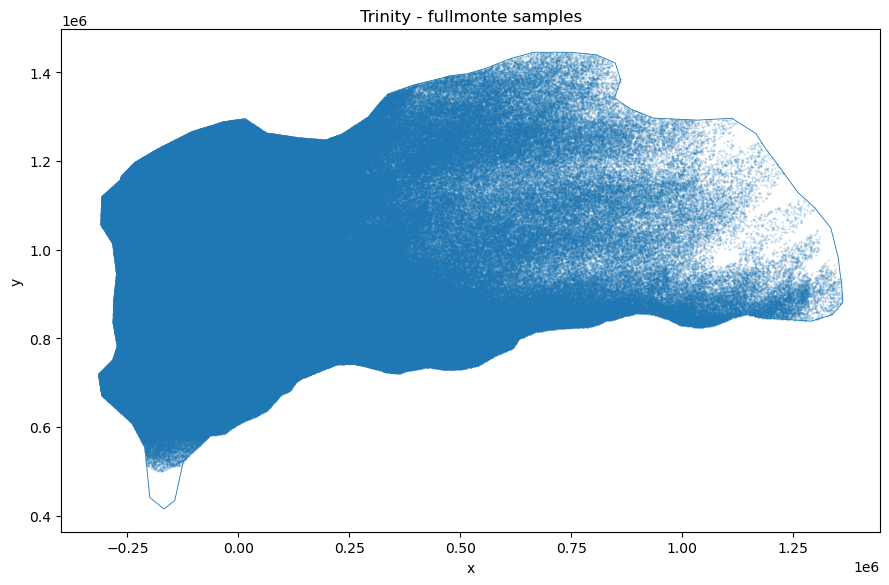

In [6]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(fullmonte_samples.newx, fullmonte_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - fullmonte samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [9]:
fullmonte_depths = StormDepthProcessor(watershed).run(fullmonte_samples, n_jobs=-1)

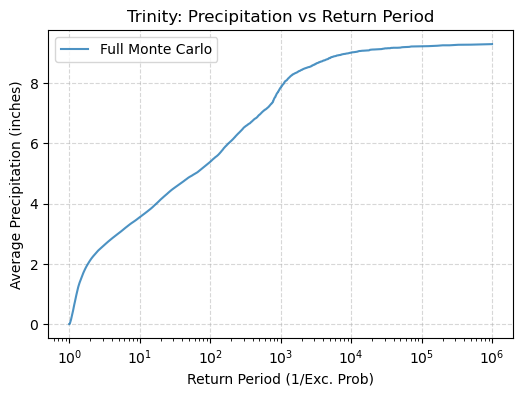

In [17]:
# Sort by exceedance probability (or return period)
df_sorted = fullmonte_depths.sort_values("exc_prb")

plt.figure(figsize=(6, 4))
plt.plot(
    1 / df_sorted["exc_prb"],        # Return period
    df_sorted["precip_avg_mm"] / 25.4,  # Convert mm → inches if needed
    label="Full Monte Carlo",
    alpha=0.8
)

plt.xscale("log")  # log scale for return period
plt.xlabel("Return Period (1/Exc. Prob)")
plt.ylabel("Average Precipitation (inches)")  # updated units
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity: Precipitation vs Return Period")
plt.show()

Importance Sampling - Truncated Normals

In [14]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"],
    "sd_y": watershed.watershed_stats["range_y"]*0.5,                            
}

sampler = ImportanceSampler(
    distribution="truncated_gaussian",
    params=params,
    num_simulations=350_000,
    num_rep=1,
    seed=42,
)

TruncNorm_samples = sampler.sample(data = watershed)

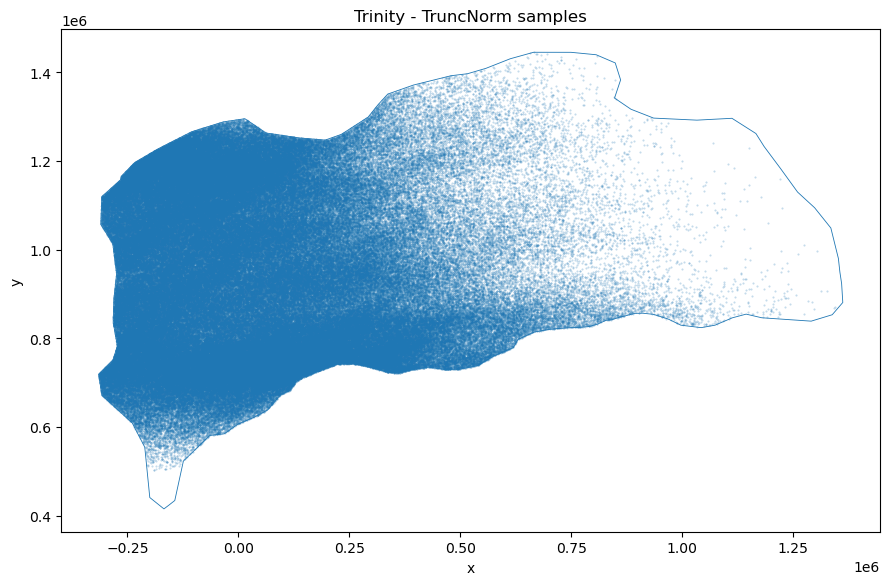

In [15]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(TruncNorm_samples.newx, TruncNorm_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - TruncNorm samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [16]:
TruncNorm_depths = StormDepthProcessor(watershed).run(TruncNorm_samples, n_jobs=-1)

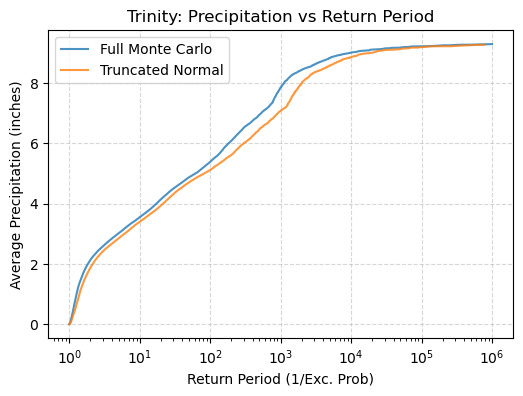

In [18]:
import matplotlib.pyplot as plt

# Sort both datasets by exceedance probability
df_full = fullmonte_depths.sort_values("exc_prb")
df_trunc = TruncNorm_depths.sort_values("exc_prb")

plt.figure(figsize=(6, 4))

# Full Monte Carlo
plt.plot(
    1 / df_full["exc_prb"], 
    df_full["precip_avg_mm"] / 25.4,
    label="Full Monte Carlo",
    alpha=0.8
)

# Truncated Normal
plt.plot(
    1 / df_trunc["exc_prb"], 
    df_trunc["precip_avg_mm"] / 25.4,
    label="Truncated Normal",
    alpha=0.8
)

plt.xscale("log")  # log scale for return period
plt.xlabel("Return Period (1/Exc. Prob)")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title("Trinity: Precipitation vs Return Period")
plt.show()

Importance Sampling - Gaussian Copula

In [21]:
#Sample
params = {
    "mu_x": watershed.watershed_stats["x"],  
    "mu_y": watershed.watershed_stats["y"],      
    "sd_x": watershed.watershed_stats["range_x"],
    "sd_y": watershed.watershed_stats["range_y"]*0.5, 
    "rho": -0.2,                                
}

sampler = ImportanceSampler(
    distribution="gaussian_copula",
    params=params,
    num_simulations=300_000,
    num_rep=1,
    seed=42,
)

Copula_samples = sampler.sample(data = watershed)

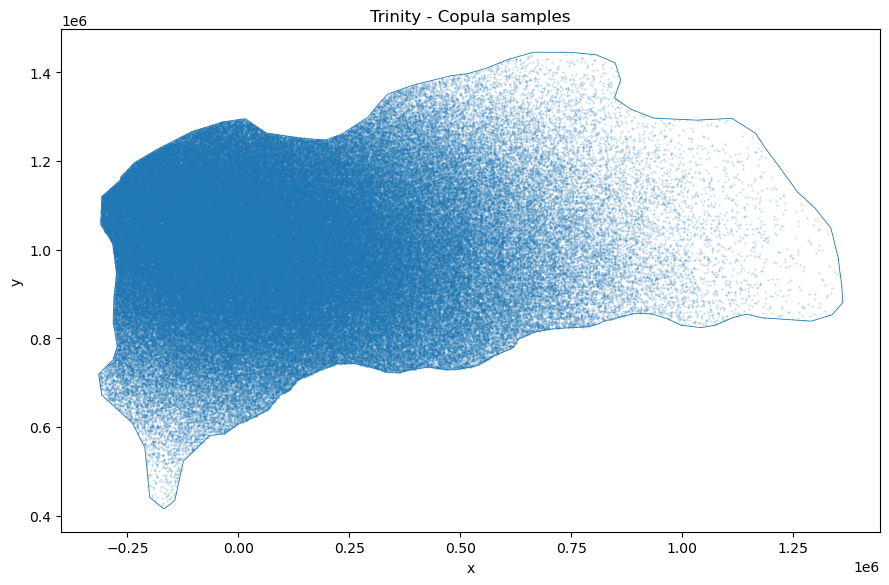

In [22]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(Copula_samples.newx, Copula_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Copula samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

Mixture of two normals

In [24]:
#Sample
params = {
    "mu_x_narrow": watershed.watershed_stats["x"],  
    "mu_y_narrow": watershed.watershed_stats["y"],
    "mu_x_wide": watershed.domain_stats["x"],  
    "mu_y_wide": watershed.domain_stats["y"],
    "sd_x_narrow": watershed.watershed_stats["range_x"]*0.3,
    "sd_y_narrow": watershed.watershed_stats["range_y"]*0.3,
    "sd_x_wide": watershed.domain_stats["range_x"],
    "sd_y_wide": watershed.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=300_000,
    num_rep=1,
    seed=42,
)

mixture_samples = sampler.sample(data = watershed)

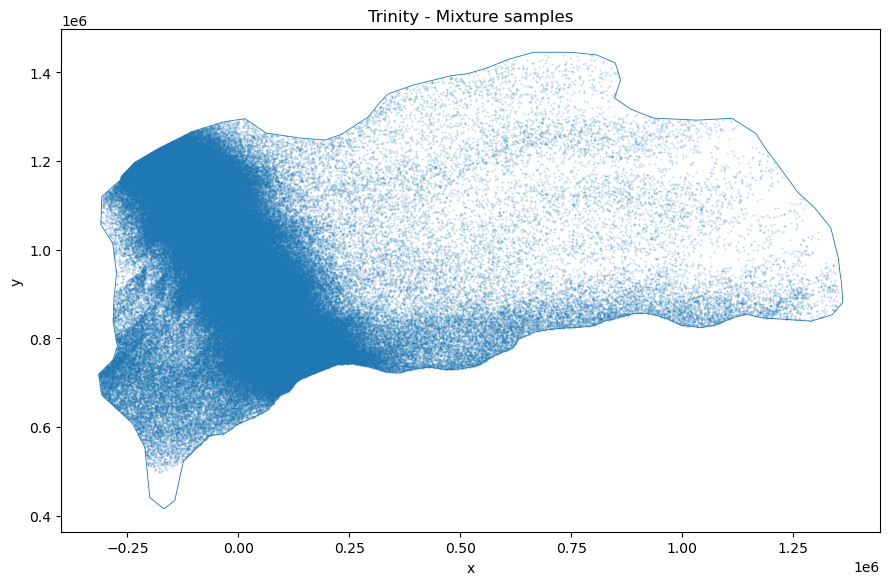

In [25]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(mixture_samples.newx, mixture_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.title(f"{watershed_name} - Mixture samples")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [26]:
mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

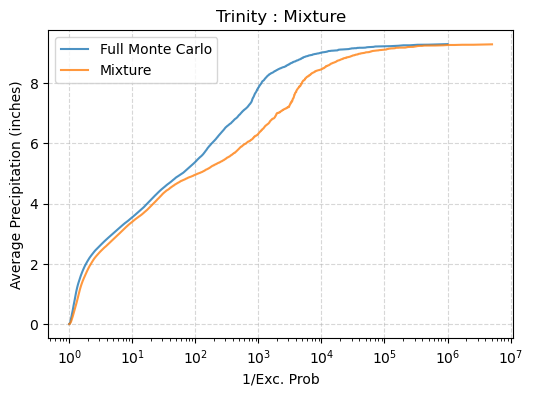

In [30]:
import matplotlib.pyplot as plt

# Sort both datasets by exceedance probability
df_full = fullmonte_depths.sort_values("exc_prb")
df_mixture = mixture_depths.sort_values("exc_prb")

plt.figure(figsize=(6, 4))

# Full Monte Carlo
plt.plot(
    1 / df_full["exc_prb"], 
    df_full["precip_avg_mm"] / 25.4,
    label="Full Monte Carlo",
    alpha=0.8
)

# Truncated Normal
plt.plot(
    1 / df_mixture["exc_prb"], 
    df_mixture["precip_avg_mm"] / 25.4,
    label="Mixture",
    alpha=0.8
)

plt.xscale("log")  # log scale for return period
plt.xlabel("1/Exc. Prob")
plt.ylabel("Average Precipitation (inches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{watershed_name} : Mixture")
plt.show()

Adaptive Mixture